In [1]:
import torch
import glob
from miditoolkit.midi import parser as mid_parser  
from miditoolkit.midi import containers as ct
import numpy as np
import matplotlib.pyplot as plt

In [45]:
NOTE_SEQUENCE = [50, 52, 55, 57, 58, 59, 60, 62, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 76, 77, 79, 81]
NOTE_CHAR_SEQUENCE = ["D,", "E,", "G,", "A,", "_B,", "B,", "C", "D", "E", "F", "_G", "G","A", "_B", "B", "c", "_d", "d", "e", "f", "g", "a"]
NOTE_SEQUENCE = list(map(lambda pitch: f"n{pitch}", NOTE_SEQUENCE))
VOCABULARY = ["p", "s", "e"] +  NOTE_SEQUENCE
LEN_VOCAB = len(VOCABULARY)

In [3]:
def load_midi_folder(path: str) -> list:
    list_path = glob.glob(path)
    midi_list = [mid_parser.MidiFile(_path) for _path in list_path]
    print(f"[INFO] Load successfully {len(midi_list)} file midi from source")
    list_path = list(map(lambda _path: _path.split("\\")[-1], list_path))
    return midi_list, list_path

In [4]:
def midi2seq(midi_list: list) -> list:
    sequences = []
    tmp_cache = {
        "note": 0,
        "track": 0
    }
    for midi in midi_list:
        notes = midi.instruments[0].notes
        tmp_cache["track"] += (notes[-1].end//(2*midi.ticks_per_beat) + (notes[-1].end%(2*midi.ticks_per_beat) != 0))
        
        sub_pitch = 0
        if len(midi.key_signature_changes):
            sub_pitch = midi.key_signature_changes[0].key_number

        sequence = list(map(lambda note: note.pitch-sub_pitch, notes))
        
        tmp_cache["note"] += len(notes)
        sequences.append(sequence)

    print("[INFO] Convert midi to sequences successfully")
    print(f"\t[+] Note: {tmp_cache['note']}")
    print(f"\t[+] Track: {tmp_cache['track']}")
    
    return sequences

In [7]:
def seq2vocab_idx(sequences: list) -> list:
    token_idx = []
    for seq in sequences:
        seq_idx = list(map(lambda pitch: VOCABULARY.index(f"n{pitch}"), seq))
        token_idx.append(seq_idx)
    return token_idx

In [11]:
def vocab_idx2tensor(tokens_idx: list) -> torch.Tensor:
    tensor_data = torch.Tensor()
    max_length = 0
    for idx, seq_idx in enumerate(tokens_idx):
        seq_idx = torch.tensor(seq_idx)
        tokens_idx[idx] = seq_idx.view(1, len(seq_idx))
        max_length = max(max_length, len(seq_idx))
    
    for seq_idx in tokens_idx:
        pad_zeros = torch.zeros((1, max_length - seq_idx.size(1)))
        st_token = torch.tensor([[1]])
        en_token = torch.tensor([[2]])
        seq_idx = torch.cat([st_token, seq_idx, pad_zeros, en_token], dim=1)
        tensor_data = torch.cat((tensor_data, seq_idx), dim=0)
    return tensor_data

In [58]:
def plot_midi_roll(midi: mid_parser.MidiFile) -> None:
    fig, ax = plt.subplots(figsize=(18, 5))
    ax.set_facecolor('White')
    start = np.zeros(len(NOTE_SEQUENCE))
    label = np.array(NOTE_SEQUENCE)
    
    notes = midi.instruments[0].notes
    for idx, note in enumerate(notes):
        pitch = note.pitch
        duration = (note.end - note.start)//30
        if idx == 0:
            start += (note.start//30)
        else:
            start += (notes[idx].start - notes[idx-1].end)//30
        width = np.zeros(len(NOTE_SEQUENCE))
        width[NOTE_SEQUENCE.index(f"n{pitch}")] = duration
        ax.barh(label, width, left=start, height=0.4, label=pitch, color="green")
        start += duration
        
    plt.xlabel("Time by tick")
    plt.ylabel("Pitch")
    plt.show()

In [12]:
path = "./datasets/midi_songs/*.mid"
midi_list, list_path = load_midi_folder(path)
sequences = midi2seq(midi_list)
tokens_idx = seq2vocab_idx(sequences)
tensor_data = vocab_idx2tensor(tokens_idx)

[INFO] Load successfully 34 file midi from source
[INFO] Convert midi to sequences successfully
	[+] Note: 3647
	[+] Track: 1174


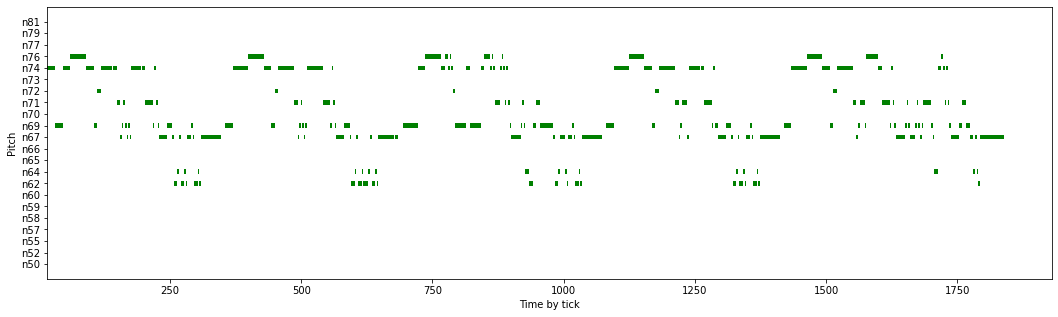

In [59]:
plot_midi_roll(midi_list[0])

In [14]:
torch.save(tensor_data, "./data_gen/data_v7.pt")

In [15]:
from train import NeuralNetwork
from model import Transformer

In [16]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
hyper_params = {
    "d_model": 256,
    "n_layers": 3,
    "n_heads": 2,
    "d_ff": 128,
    "max_relative_dist": 512,
    "max_position": 512,
    "vocab_size": len(VOCABULARY),
    "dropout": 0.3,
    "norm_eps": 1e-3,
    "bias": True
}
data_path = "./data_gen/data_v7.pt"
cpk_path = "./checkpoints/model_v7.pt"
epoch = 10
batch_size = 1
pretrain = False

In [17]:
model = NeuralNetwork(
    hyper_params=hyper_params,
    data_path=data_path,
    batch_size=batch_size,
    check_point_path=cpk_path,
    warmup_steps=4000,
    test_size=0.3, 
    load_check_point=pretrain,
    device=device
)
model.fit(epoch)

Epoch:  1/10
	Train process:  ◒ |▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇| 100.0% 0.01s/step - Loss: 3.31229 - Acc: 0.05 
	Valid process:  ◒ |▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇| 100.0% 0.0s/step - Loss: 3.16765 - Acc: 0.01 m
=> Train loss: 3.47293 - Train acc: 0.04 - Valid loss: 3.16501 - Valid acc: 0.02  - Time: 0.64s/epoch
Epoch:  2/10
	Train process:  ◒ |▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇| 100.0% 0.02s/step - Loss: 2.83991 - Acc: 0.2 m
	Valid process:  ◒ |▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇| 100.0% 0.0s/step - Loss: 1.40192 - Acc: 0.83 
=> Train loss: 3.06482 - Train acc: 0.13 - Valid loss: 1.7793 - Valid acc: 0.7  - Time: 0.66s/epoch
Epoch:  3/10
	Train process:  ◒ |▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇| 100.0% 0.01s/step - Loss: 1.5153 - Acc: 0.8 mm
	Valid process:  ◒ |▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇| 100.0% 0.0s/step - Loss: 1.35783 - Acc: 0.75 
=> Train loss: 2.23249 - Train acc: 0.54 - Valid loss: 1.48731 - Valid acc: 0.7  - Time: 0.63s/epoch
Epoch:  4/10
	Train process:  ◒ |▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇| 1

In [43]:
def generate(model: Transformer, x: list) -> torch.Tensor:
    x = torch.tensor(x).to("cuda:0" if torch.cuda.is_available() else "cpu").long()
    x = x.unsqueeze(0)
    with torch.no_grad():
        while True:
            pred = model(x)
            k_top_pred = torch.topk(pred[0, -1, :], k=8, dim=0)
            pred_idx = torch.distributions.Categorical(logits=k_top_pred.values).sample()

            pred = k_top_pred.indices[pred_idx]
            if pred.item() == 2:
                break
            if x.size(1) > 363:
                break
            x = torch.cat((x, pred.view(1, 1)), dim=1)
    return x.squeeze()[1:]

In [52]:
gen_data = generate(model.model, [1])
gen_data

tensor([14, 15, 14, 14, 18, 14, 14, 14, 10, 11, 12, 14, 11, 14, 18, 11, 14, 18,
        18, 18, 10,  9, 11, 14, 14, 14, 14, 15, 14, 11, 14, 18, 10, 20, 14, 10,
        14, 15, 18, 14, 14, 10, 14, 11, 14, 10,  9, 14, 14, 18, 20, 10, 14, 15,
        11, 15, 10, 11, 10, 18, 18, 12, 15, 11, 14, 10, 14, 14, 18, 18, 10, 10,
        18, 18, 10, 14, 11, 14, 15, 14, 18, 14, 14,  9, 20, 20, 18, 15,  9, 14,
        18, 14, 14, 10, 10, 10,  9, 20, 20, 18, 15, 14, 10, 14, 14, 10, 20, 15,
        18, 14, 10, 10, 14, 14, 10,  9, 14, 10, 18, 10, 20, 18, 14, 15, 14, 14,
        18, 10, 10,  9, 18, 15, 14, 20, 18, 18, 11, 14, 15, 10, 18, 10, 14, 14,
        11, 14, 10, 10, 10,  9, 14, 15, 15, 14,  9, 20, 14, 10, 10, 14, 15, 18,
        14, 20, 20, 14, 14, 11, 10, 12, 20, 10, 14, 18, 15, 11, 10, 14, 11, 15,
        14,  9,  9,  9, 20, 18, 20, 10, 14, 10, 20, 20, 14, 18, 20, 20,  9, 10,
        20, 14, 11,  9, 10, 10, 14, 15, 14, 15, 12, 10, 10,  9, 14, 10,  9, 14,
        20, 18, 12, 14, 14, 11, 10, 10, 

In [56]:
import random
def token2midi(tokens: torch.Tensor, save_path: str) -> None:
    path = "./datasets/midi_songs/*.mid"
    midi_list, list_path = load_midi_folder(path)
    midi_list = list(filter(lambda midi: len(midi.time_signature_changes) == 1 ,midi_list))
    midi_list = list(filter(lambda midi: midi.time_signature_changes[0].numerator==2, midi_list))
    midi_list = list(filter(lambda midi: midi.time_signature_changes[0].denominator==4, midi_list))
    N = len(midi_list)
    idx = random.randint(0, N-1)
    _notes = []
    midi_object = midi_list[idx]
    midi_notes = midi_object.instruments[0].notes
    min_length = min(len(midi_notes), len(tokens))
    for idx_note in range(min_length):
        current_note = midi_notes[idx_note]
        pitch = VOCABULARY[int(tokens[idx_note])].split("n")[-1]
        current_note.pitch = int(pitch)
        #         current_note.pitch = int(tokens[idx_note]) + 48
        _notes.append(current_note)
    midi_object.instruments[0].notes = _notes 
    print("[INFO] Save successfully new midi file:", save_path)
    midi_object.dump(save_path)

In [57]:
token2midi(gen_data,"./midi_gen/b1724.mid")

[INFO] Load successfully 34 file midi from source
[INFO] Save successfully new midi file: ./midi_gen/b1724.mid


In [2]:
midi = mid_parser.MidiFile("./midi_gen/b1524.mid")

In [4]:
dir(midi)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_convert_delta_to_cumulative',
 '_load_instruments',
 '_load_key_signatures',
 '_load_lyrics',
 '_load_markers',
 '_load_tempo_changes',
 '_load_time_signatures',
 'dump',
 'get_tick_to_time_mapping',
 'instruments',
 'key_signature_changes',
 'lyrics',
 'markers',
 'max_tick',
 'tempo_changes',
 'ticks_per_beat',
 'time_signature_changes']

In [16]:
midi.max_tick

14857

In [15]:
midi.instruments[0].notes

[Note(start=0, end=455, pitch=67, velocity=80),
 Note(start=480, end=707, pitch=69, velocity=80),
 Note(start=720, end=833, pitch=67, velocity=80),
 Note(start=840, end=953, pitch=67, velocity=80),
 Note(start=960, end=1643, pitch=69, velocity=80),
 Note(start=1680, end=1793, pitch=67, velocity=80),
 Note(start=1800, end=1913, pitch=67, velocity=80),
 Note(start=1920, end=2147, pitch=69, velocity=80),
 Note(start=2160, end=2387, pitch=72, velocity=80),
 Note(start=2400, end=2627, pitch=64, velocity=80),
 Note(start=2640, end=2753, pitch=72, velocity=80),
 Note(start=2760, end=2873, pitch=72, velocity=80),
 Note(start=2880, end=3791, pitch=67, velocity=80),
 Note(start=3840, end=4181, pitch=72, velocity=80),
 Note(start=4200, end=4313, pitch=67, velocity=80),
 Note(start=4320, end=4661, pitch=69, velocity=80),
 Note(start=4680, end=4793, pitch=69, velocity=80),
 Note(start=4800, end=5141, pitch=72, velocity=80),
 Note(start=5160, end=5273, pitch=72, velocity=80),
 Note(start=5280, end=5

In [73]:
from fractions import Fraction
def midi2raw_data(midi: mid_parser.MidiFile) -> list:
    ticks = 2*midi.ticks_per_beat
    notes = midi.instruments[0].notes
    for i in range(1, len(notes)):
        if notes[i].start - notes[i].end < 60:
            notes[i-1].end = notes[i].start
    len_track = midi.max_tick//ticks
    raw_data = [[] for _ in range(len_track+1)]
    for idx, note in enumerate(notes):
        duration = note.end - note.start
        idx_pitch = NOTE_SEQUENCE.index(f"n{note.pitch}")
        note_char = NOTE_CHAR_SEQUENCE[idx_pitch]
        frac = Fraction(duration, ticks)
        track_id = note.start//ticks
        if frac.numerator == 1:
            value = frac.denominator
            raw_data[track_id].append(f"{note_char}{8//value}")
        else:
            if frac.numerator != 3:
                continue
            value = frac.denominator//2
            raw_data[track_id].append(f"{note_char}{8//value}>")
    return raw_data
    

In [76]:
raw = midi2raw_data(midi)

In [85]:
string_data = []
for data in raw:
    string_data.append(" ".join(data))
string_data = string_data[: -1]
n_block = len(string_data)//3 + (len(string_data)%3 != 0)
raw_data = []
for i in range(n_block):
    st = i*3
    en = (i+1)*3
    raw_data.append(" | ".join(string_data[st: en]))
"\n".join(raw_data)

'G4 A2 G1 G1 | A4> G1 G1 | A2 c2 E2 c1 c1\nG8 | c2> G1 A2> A1 | c2> c1 c2 D2\nd8 | G4 G2 G2 | G4> A1 G1\nG2 G2 G2 A1 c1 | A4 G2 D1 A1 | c4 d4\nc2> C1 D1 D1 G2 | G2> c1 G1 G1 E2 | c8'

In [61]:
midi.instruments[0].notes

[Note(start=0, end=480, pitch=67, velocity=80),
 Note(start=480, end=720, pitch=69, velocity=80),
 Note(start=720, end=840, pitch=67, velocity=80),
 Note(start=840, end=960, pitch=67, velocity=80),
 Note(start=960, end=1680, pitch=69, velocity=80),
 Note(start=1680, end=1800, pitch=67, velocity=80),
 Note(start=1800, end=1920, pitch=67, velocity=80),
 Note(start=1920, end=2160, pitch=69, velocity=80),
 Note(start=2160, end=2400, pitch=72, velocity=80),
 Note(start=2400, end=2640, pitch=64, velocity=80),
 Note(start=2640, end=2760, pitch=72, velocity=80),
 Note(start=2760, end=2880, pitch=72, velocity=80),
 Note(start=2880, end=3840, pitch=67, velocity=80),
 Note(start=3840, end=4200, pitch=72, velocity=80),
 Note(start=4200, end=4320, pitch=67, velocity=80),
 Note(start=4320, end=4680, pitch=69, velocity=80),
 Note(start=4680, end=4800, pitch=69, velocity=80),
 Note(start=4800, end=5160, pitch=72, velocity=80),
 Note(start=5160, end=5280, pitch=72, velocity=80),
 Note(start=5280, end=5

In [22]:
len()

683

In [42]:
1680 - 960


720

In [2]:
tensor_data = torch.load("./data_gen/data_v7.pt")

In [4]:
tensor_data[0]

tensor([ 1., 14., 10., 14., 14., 15., 15., 14., 14., 10., 12., 14., 14., 11.,
         9., 10., 11., 10.,  9., 10.,  9., 14., 14., 11., 11., 10., 14., 11.,
        10.,  9., 10., 10.,  9.,  5.,  6.,  9.,  5.,  6.,  5.,  9., 10.,  9.,
         5.,  6.,  5.,  9.,  9., 10., 10., 14., 14., 14., 15., 15., 14., 14.,
        10., 12., 14., 14., 11.,  9., 10., 11., 10.,  9., 10., 14., 14., 11.,
        11., 10., 14., 11., 10.,  9., 10., 10.,  9.,  5.,  6.,  9.,  5.,  6.,
         5.,  5.,  6.,  9.,  5.,  6.,  5.,  9.,  9., 10., 10., 10., 14., 14.,
        15., 15., 14., 15., 14., 15., 14., 12., 10., 10., 14., 10., 10., 10.,
        14., 15., 14., 15., 14., 11., 11., 14., 15., 14., 11., 14., 11., 10.,
         9.,  9., 10., 11., 10.,  6.,  5., 10., 11., 10., 10., 10.,  9.,  5.,
         6.,  9.,  9.,  6.,  5.,  9., 10.,  9.,  5.,  6.,  5.,  9.,  9., 10.,
        10., 14., 14., 14., 15., 15., 14., 14., 10., 12., 14., 14., 11.,  9.,
        10., 11., 11.,  9., 14., 14., 11., 11., 10., 14., 10., 1